In [1]:
import pandas as pd

drivers = pd.read_csv(r"D:\Desktop\APPLIED DS\AWS_SELECTED_FILES\drivers.csv")
lap_times = pd.read_csv(r"D:\Desktop\APPLIED DS\AWS_SELECTED_FILES\lap_times.csv")
pit_stops = pd.read_csv(r"D:\Desktop\APPLIED DS\AWS_SELECTED_FILES\pit_stops.csv")
races = pd.read_csv(r"D:\Desktop\APPLIED DS\AWS_SELECTED_FILES\races.csv")
results = pd.read_csv(r"D:\Desktop\APPLIED DS\AWS_SELECTED_FILES\results.csv")

In [8]:
results_small = results[["raceId", "driverId", "constructorId", "grid", "laps", "statusId", "positionOrder", "points"]]
races_small = races[["raceId", "year", "round", "circuitId"]]
merged = results_small.merge(races_small, on="raceId", how="left")
drivers_small = drivers[["driverId", "nationality"]]
merged = merged.merge(drivers_small, on="driverId", how="left")
merged = merged.dropna(subset=["positionOrder"])

X = merged.drop(columns=["positionOrder"])
y = merged["positionOrder"] 
X = pd.get_dummies(X, columns=["nationality", "constructorId", "statusId", "circuitId"])

print(X.shape)
print( y.shape)

(26080, 472)
(26080,)


In [9]:
pip install mlflow

   ---------------------------------------- 0.0/28.2 MB ? eta -:--:--
   - -------------------------------------- 1.3/28.2 MB 6.7 MB/s eta 0:00:05
   ---- ----------------------------------- 2.9/28.2 MB 7.3 MB/s eta 0:00:04
   ------ --------------------------------- 4.5/28.2 MB 7.5 MB/s eta 0:00:04
   --------- ------------------------------ 6.6/28.2 MB 7.9 MB/s eta 0:00:03
   ----------- ---------------------------- 8.1/28.2 MB 7.9 MB/s eta 0:00:03
   -------------- ------------------------- 10.2/28.2 MB 8.1 MB/s eta 0:00:03
   ----------------- ---------------------- 12.3/28.2 MB 8.4 MB/s eta 0:00:02
   -------------------- ------------------- 14.7/28.2 MB 8.8 MB/s eta 0:00:02
   ------------------------ --------------- 17.6/28.2 MB 9.2 MB/s eta 0:00:02
   ---------------------------- ----------- 20.2/28.2 MB 9.7 MB/s eta 0:00:01
   -------------------------------- ------- 23.1/28.2 MB 10.0 MB/s eta 0:00:01
   ---------------------------------- ----- 24.6/28.2 MB 9.8 MB/s eta 0:00:0

In [10]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

2025/04/09 13:38:24 INFO mlflow.tracking.fluent: Experiment with name 'f1_model_experiment' does not exist. Creating a new experiment.
2025/04/09 13:39:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Let's see the results on MLflow UI


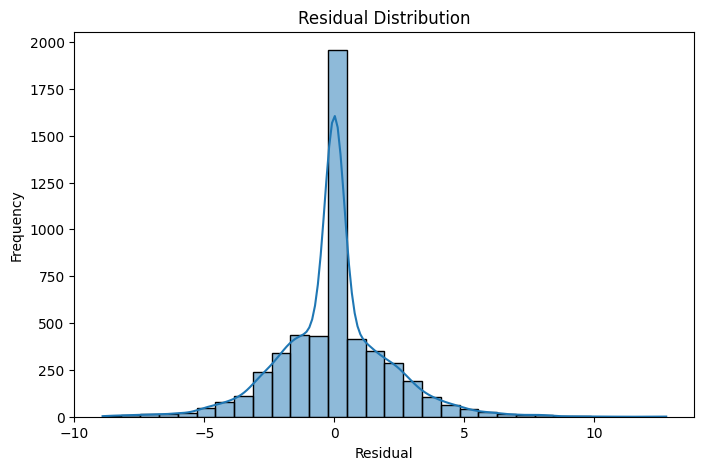

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlflow.set_experiment("f1_model_experiment")

with mlflow.start_run():
    params = {
        "n_estimators": 100,
        "max_depth": 10,
        "random_state": 42
    }

    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_params(params)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2_score", r2)
    mlflow.sklearn.log_model(model, "model")

    residuals = y_test - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title("Residual Distribution")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    os.makedirs("plots", exist_ok=True)
    plot_path = "plots/residuals.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

    pred_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
    pred_path = "plots/predictions.csv"
    pred_df.to_csv(pred_path, index=False)
    mlflow.log_artifact(pred_path)

print("Let's see the results on MLflow UI")

In [13]:
import numpy as np

param_grid = [
    {'n_estimators': 50, 'max_depth': 5},
    {'n_estimators': 100, 'max_depth': 5},
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 150, 'max_depth': 10},
    {'n_estimators': 200, 'max_depth': 10},
    {'n_estimators': 100, 'max_depth': 15},
    {'n_estimators': 150, 'max_depth': 15},
    {'n_estimators': 200, 'max_depth': 15},
    {'n_estimators': 250, 'max_depth': 20},
    {'n_estimators': 300, 'max_depth': 20},
]

mlflow.set_experiment("f1_model_experiment")

for i, params in enumerate(param_grid):
    with mlflow.start_run(run_name=f"run_{i+1}"):
        model = RandomForestClassifier(n_estimators=params['n_estimators'],
                                       max_depth=params['max_depth'],
                                       random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)

        mlflow.log_param("n_estimators", params['n_estimators'])
        mlflow.log_param("max_depth", params['max_depth'])
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(model, "model")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plot_path = f"conf_matrix_{i+1}.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.close()

        report = classification_report(y_test, y_pred)
        report_path = f"classification_report_{i+1}.txt"
        with open(report_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(report_path)

2025/04/09 13:44:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\ACE\AppData\Local\Temp\tmp6vonfnuz\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/09 13:44:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\ACE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACE\AppData\Local\Packages\PythonSoftwareFoundati

2025/04/09 13:44:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\ACE\AppData\Local\Temp\tmphcjyoti3\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/09 13:44:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\ACE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACE\AppData\Local\Packages\PythonSoftwareFoundati

In [14]:
best_params = {"n_estimators": 300, "max_depth": 20}
best_accuracy = 0.32611196319018404

After running 10 different ML experiments with varying hyperparameters, I selected the best model based on highest accuracy on the test set.
The best performing model was a RandomForestClassifier with:

n_estimators = 300

max_depth = 20

accuracy =  0.32611196319018404

I selected this model (run 10) because it achieved the best balance between performance and simplicity among all 10 runs.